In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
btc_data = pd.read_csv(
    Path('../RJM-Algo-Trading/Resources/btc_price_data.csv'),
    index_col="Date",
    parse_dates=True, 
    infer_datetime_format=True
)
btc_data.head()

,Volume,Volume Weight,Open,Close,High,Low,Transactions
Date,,,,,,,
2022-01-01,14516.208110,47107.5183,46211.24,47733.43,47967.120000,46150.00,465519
2022-01-02,10724.093860,47243.3904,47746.00,47299.07,48012.000000,46633.36,431851
2022-01-03,16693.028505,46630.0499,47297.66,46459.56,47586.580000,45689.00,450817
2022-01-04,24161.282655,46464.5600,46459.57,45814.61,47671.862805,45515.00,556220
2022-01-05,39467.849850,45006.0060,45817.13,43436.04,47076.550000,42413.59,798720


In [3]:
btc_data['daily_returns'] = btc_data['Close'].pct_change()
btc_data['daily_returns_lagged'] = btc_data['daily_returns'].shift(1)
btc_data['trade_type'] =np.where(btc_data['daily_returns_lagged']<0,1,-1)
btc_data.head()

,Volume,Volume Weight,Open,Close,High,Low,Transactions,daily_returns,daily_returns_lagged,trade_type
Date,,,,,,,,,,
2022-01-01,14516.208110,47107.5183,46211.24,47733.43,47967.120000,46150.00,465519,NaN,NaN,-1
2022-01-02,10724.093860,47243.3904,47746.00,47299.07,48012.000000,46633.36,431851,-0.009100,NaN,-1
2022-01-03,16693.028505,46630.0499,47297.66,46459.56,47586.580000,45689.00,450817,-0.017749,-0.009100,1
2022-01-04,24161.282655,46464.5600,46459.57,45814.61,47671.862805,45515.00,556220,-0.013882,-0.017749,1
2022-01-05,39467.849850,45006.0060,45817.13,43436.04,47076.550000,42413.59,798720,-0.051917,-0.013882,1


In [4]:
y = btc_data['trade_type']
X = btc_data.drop(columns='trade_type')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
X_train.shape

(409, 9)

In [6]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

In [7]:
X_train_imputed = imp.transform(X_train)
X_test_imputed = imp.transform(X_test)

In [8]:
classifier = SVC(kernel='linear')
classifier.fit(X_train_imputed, y_train)

SVC(kernel='linear')

In [9]:
print(f"Training Data Score: {classifier.score(X_train_imputed, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_imputed, y_test)}")

Training Data Score: 0.5476772616136919
Testing Data Score: 0.5620437956204379


In [10]:
predictions = classifier.predict(X_test_imputed)
results = pd.DataFrame({
    "Prediction": predictions, 
    "Actual": y_test
}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,-1,-1
1,1,-1
2,1,1
3,1,-1
4,1,1


In [11]:
confusion_matrix(y_test, predictions)

array([[23, 42],
       [18, 54]], dtype=int64)

In [13]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.56      0.35      0.43        65
           1       0.56      0.75      0.64        72

    accuracy                           0.56       137
   macro avg       0.56      0.55      0.54       137
weighted avg       0.56      0.56      0.54       137



In [14]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train_imputed)
X_train_scaled = X_scaler.transform(X_train_imputed)
X_test_scaled = X_scaler.transform(X_test_imputed)

In [15]:
classifier.fit(X_train_scaled, y_train)

SVC(kernel='linear')

In [16]:
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Training Data Score: 0.980440097799511
Testing Data Score: 0.9708029197080292


In [37]:
predictions_scaled = classifier.predict(X_test_scaled)
results_scaled = pd.DataFrame({
    "Prediction": predictions_scaled, 
    "Actual": y_test
})
results_scaled.head()

,Prediction,Actual
Date,,
2023-02-02,-1,-1
2022-02-07,-1,-1
2022-10-19,1,1
2022-02-09,-1,-1
2022-12-17,1,1


In [38]:
confusion_matrix(y_test, predictions_scaled)

array([[61,  4],
       [ 0, 72]], dtype=int64)

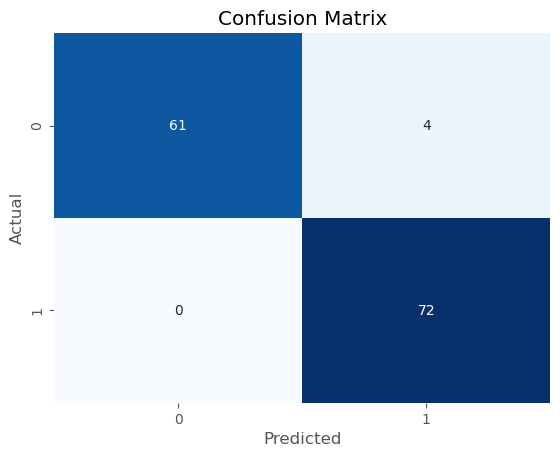

<Figure size 640x480 with 0 Axes>

In [51]:
# Create a confusion matrix heatmap
import seaborn as sns
cm = confusion_matrix(y_test, predictions_scaled)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('Confusion Matrix.png')

In [40]:
print(classification_report(y_test, predictions_scaled))

              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        65
           1       0.95      1.00      0.97        72

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137



In [46]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(classifier, X_train_scaled, y_train, train_sizes=train_sizes, cv=5)

In [47]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

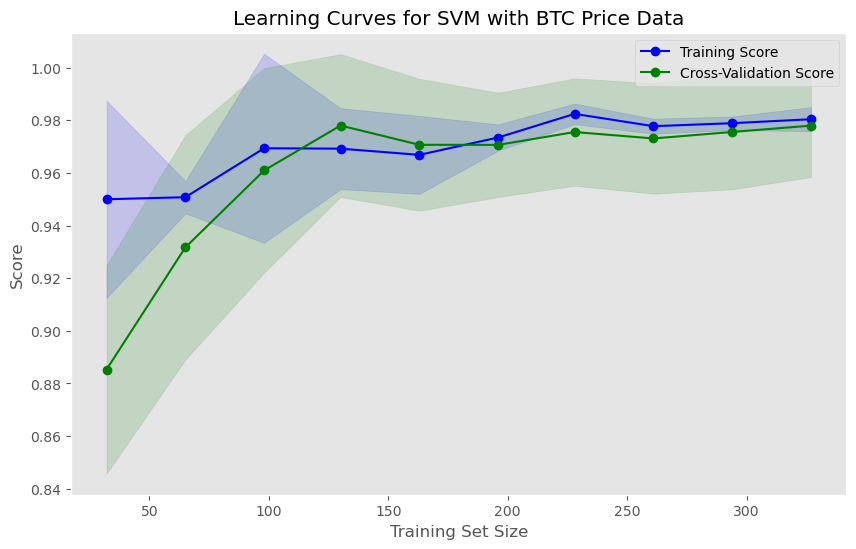

<Figure size 640x480 with 0 Axes>

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, marker='o', color='b', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='b')
plt.plot(train_sizes, test_mean, marker='o', color='g', label='Cross-Validation Score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curves for SVM with BTC Price Data')
plt.legend(loc='best')
plt.grid()
plt.show()
plt.savefig('Learning Curves for SVM.png')